# Parte 6

Aqui é realizado o teste de dois algoritmos para a previsão da série temporal de demanda.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose 
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
import warnings
warnings.filterwarnings("ignore")

### 1 - Importação e tratamento dos dados (apenas a partir de jan/ 2019)

In [20]:
df_1 = pd.read_csv('Demanda\Demanda_2019.csv', sep=';', header=None, names=['Horário','Data', 'Demanda', 'Unidade'],skiprows=5,
                parse_dates=True) 
df_2 = pd.read_csv('Demanda\Demanda_2020.csv', sep=';', header=None, names=['Horário','Data', 'Demanda', 'Unidade'],skiprows=5,
                parse_dates=True) 
df= pd.concat([df_1, df_2],ignore_index=True)
df.head()

,Horário,Data,Demanda,Unidade
0,00:00:00,01/01/2019 00:00:00 (hv),"3.479,00",MW F
1,00:01:00,01/01/2019 00:01:00 (hv),"3.471,00",MW F
2,00:02:00,01/01/2019 00:02:00 (hv),"3.468,00",MW F
3,00:03:00,01/01/2019 00:03:00 (hv),"3.466,00",MW F
4,00:04:00,01/01/2019 00:04:00 (hv),"3.457,00",MW F


In [21]:
df['Demanda'] = df['Demanda'].str[:-3]
df['Demanda'] = pd.to_numeric(df['Demanda'], errors='coerce')
df.head(15)

,Horário,Data,Demanda,Unidade
0,00:00:00,01/01/2019 00:00:00 (hv),3.479,MW F
1,00:01:00,01/01/2019 00:01:00 (hv),3.471,MW F
2,00:02:00,01/01/2019 00:02:00 (hv),3.468,MW F
3,00:03:00,01/01/2019 00:03:00 (hv),3.466,MW F
4,00:04:00,01/01/2019 00:04:00 (hv),3.457,MW F
5,00:05:00,01/01/2019 00:05:00 (hv),3.461,MW F
6,00:06:00,01/01/2019 00:06:00 (hv),3.450,MW F
7,00:07:00,01/01/2019 00:07:00 (hv),3.446,MW F
8,00:08:00,01/01/2019 00:08:00 (hv),3.453,MW F
9,00:09:00,01/01/2019 00:09:00 (hv),3.455,MW F


In [22]:
df.dtypes

Horário     object
Data        object
Demanda    float64
Unidade     object
dtype: object

In [23]:
df = df.drop(columns=['Unidade','Horário'])
df['Data'] = df['Data'].str[:16]
df['Data'] = pd.to_datetime(df['Data'], format = '%d/%m/%Y %H:%M', errors='coerce')

In [24]:
df.head()

,Data,Demanda
0,2019-01-01 00:00:00,3.479
1,2019-01-01 00:01:00,3.471
2,2019-01-01 00:02:00,3.468
3,2019-01-01 00:03:00,3.466
4,2019-01-01 00:04:00,3.457


**Fazendo uma reamostragem a cada 1 hora**

In [25]:
df_new = df.resample('60T', on='Data').mean()
df_new.head()

,Demanda
Data,
2019-01-01 00:00:00,3.485267
2019-01-01 01:00:00,3.605617
2019-01-01 02:00:00,3.605067
2019-01-01 03:00:00,3.504133
2019-01-01 04:00:00,3.406083


In [26]:
df_new.index.freq='H'
df_new['Demanda']=df_new['Demanda']*1000

In [27]:
df_new.head()

,Demanda
Data,
2019-01-01 00:00:00,3485.266667
2019-01-01 01:00:00,3605.616667
2019-01-01 02:00:00,3605.066667
2019-01-01 03:00:00,3504.133333
2019-01-01 04:00:00,3406.083333


In [28]:
df_new.describe()

,Demanda
count,14437.000000
mean,3737.370996
std,888.263103
min,1483.116667
25%,3055.633333
50%,3786.466667
75%,4337.466667
max,6938.266667


**Vamos separar apenas 5 semanas em um novo dataset. Foi escolhido um mês sem feriados para facilitar a análise.**

In [10]:
data  = df_new.loc['2019-07-22 00:00:00':'2019-08-26 00:00:00']

### Modelagem

**Divisão dos dados**

As 3 primeiras semanas serão utilizadas para treino, a semana 4 para validação e a semana 5 para teste do modelo.

In [12]:
train_data  = data.iloc[:int(((len(data)-1)/5)*3)]
valid_data = data.iloc[int(((len(data)-1)/5)*3):int(((len(data)-1)/5)*4)]
test_data = data.iloc[int(((len(data)-1)/5)*4):]

#### 1. Exponential Smoothing (Holt Winters - Considera sazonalidade e tendência)

In [13]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

***1.1 Tendência multiplicativa e sazonalidade multiplicativa***

In [14]:
model_1 = ExponentialSmoothing(train_data['Demanda'],
                                    trend='mul',
                                    seasonal = 'mul',
                                    seasonal_periods=24*7).fit()

In [15]:
predictions_1 = model_1.forecast(len(valid_data))

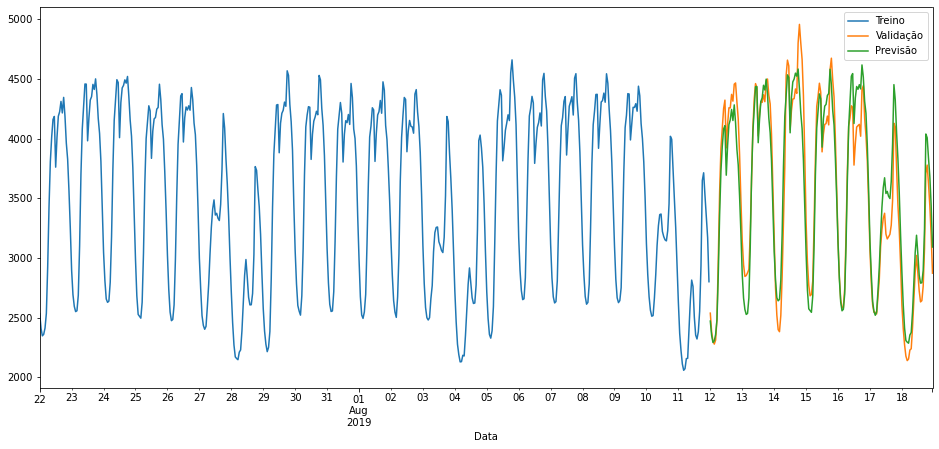

In [16]:
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,7));
valid_data['Demanda'].plot(legend=True, label='Validação', figsize=(16,7));
predictions_1.plot(legend=True, label='Previsão', figsize=(16,7));

In [17]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_1))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 223.21


***1.2 Tendência aditiva e sazonalidade multiplicativa***

In [34]:
model_2 = ExponentialSmoothing(train_data['Demanda'],
                                    trend='add',
                                    seasonal = 'mul',
                                    seasonal_periods=24*7).fit()
predictions_2 = model_2.forecast(len(valid_data))

<AxesSubplot:xlabel='Data'>

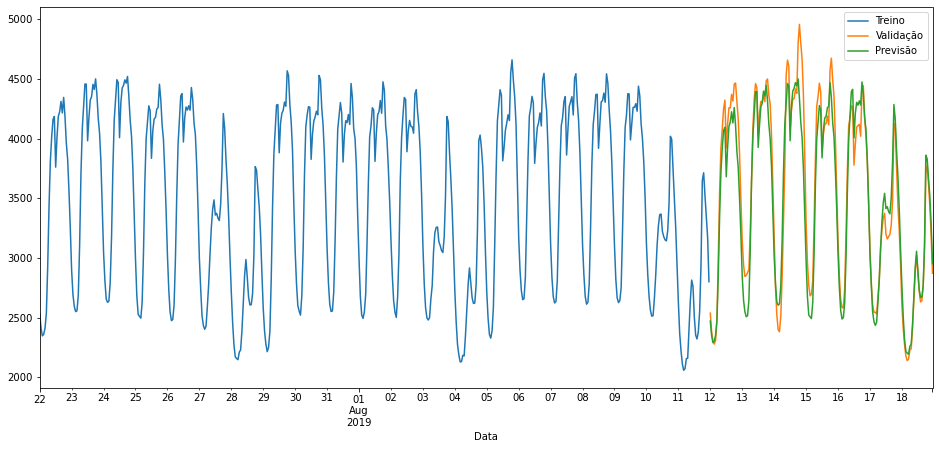

In [37]:
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,7))
valid_data['Demanda'].plot(legend=True, label='Validação', figsize=(16,7))
predictions_2.plot(legend=True, label='Previsão', figsize=(16,7))

In [39]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_2))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 205.63


***1.3 Tendência e sazonalidade aditiva***

In [41]:
model_3 = ExponentialSmoothing(train_data['Demanda'],
                                    trend='add',
                                    seasonal = 'add',
                                    seasonal_periods=24*7).fit()
predictions_3 = model_3.forecast(len(valid_data))

<AxesSubplot:xlabel='Data'>

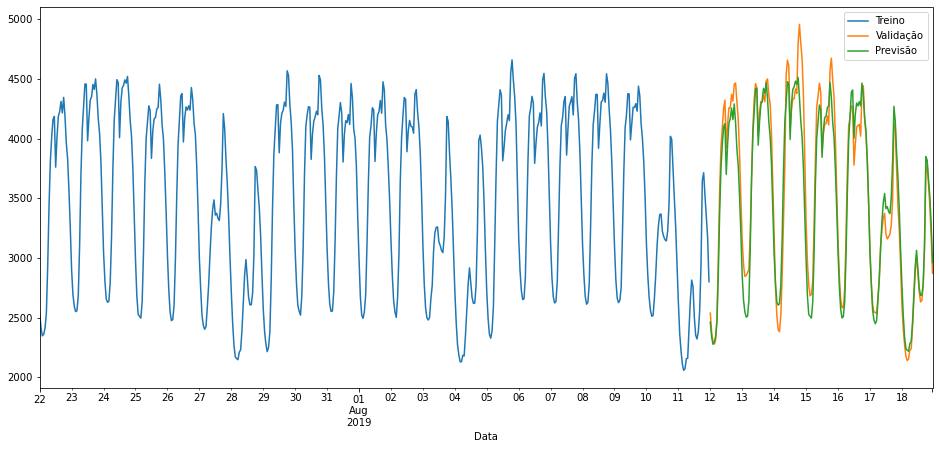

In [44]:
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,7))
valid_data['Demanda'].plot(legend=True, label='Validação', figsize=(16,7))
predictions_3.plot(legend=True, label='Previsão', figsize=(16,7))

In [45]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_3))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 201.11


***1.4 Tendência multiplicativa e sazonalidade aditiva***

In [46]:
model_4 = ExponentialSmoothing(train_data['Demanda'],
                                    trend='mul',
                                    seasonal = 'add',
                                    seasonal_periods=24*7).fit()
predictions_4 = model_4.forecast(len(valid_data))

<AxesSubplot:xlabel='Data'>

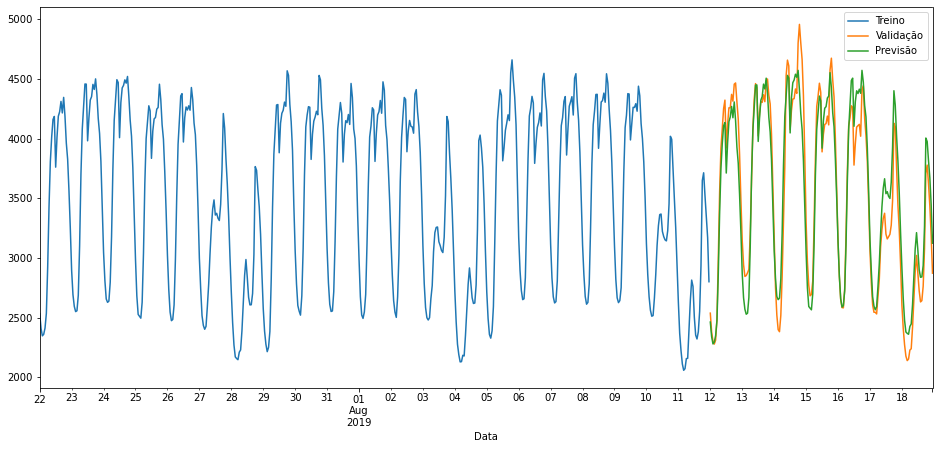

In [47]:
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,7))
valid_data['Demanda'].plot(legend=True, label='Validação', figsize=(16,7))
predictions_4.plot(legend=True, label='Previsão', figsize=(16,7))

In [49]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_4))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 221.39


***1.5 Sem tendência e sazonalidade aditiva***

In [56]:
model_5 = ExponentialSmoothing(train_data['Demanda'],
                                    #trend='mul',
                                    seasonal = 'add',
                                    seasonal_periods=24*7).fit()
predictions_5 = model_5.forecast(len(valid_data))

<AxesSubplot:xlabel='Data'>

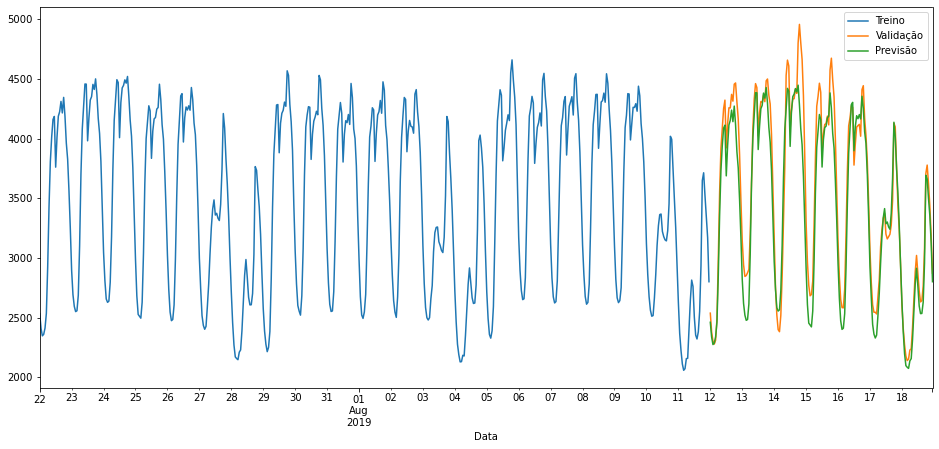

In [57]:
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,7))
valid_data['Demanda'].plot(legend=True, label='Validação', figsize=(16,7))
predictions_5.plot(legend=True, label='Previsão', figsize=(16,7))

In [58]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_5))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 221.91


***1.6 Tendência aditiva e sazonalidade multiplicativa. Alterando parâmetros: smoothing_level=0,9.***

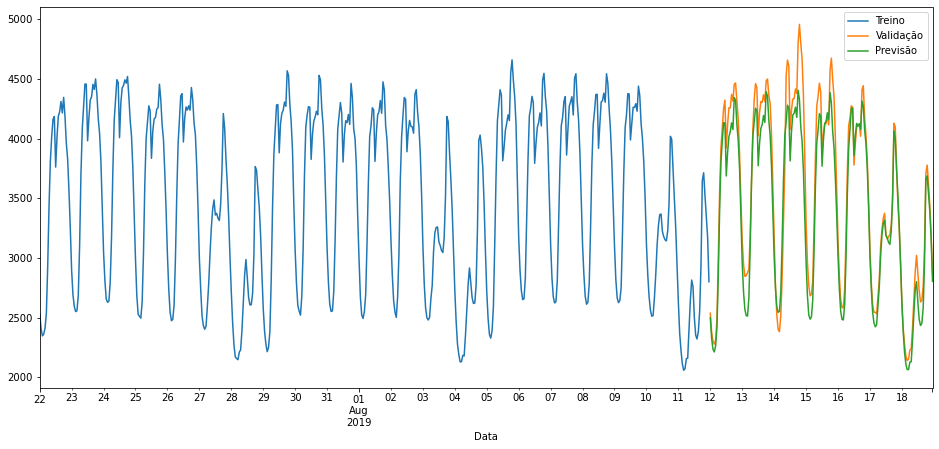

In [199]:
model_6 = ExponentialSmoothing(train_data['Demanda'],                                    
                               trend='add',     
                               seasonal = 'mul',
                                    seasonal_periods=24*7).fit(smoothing_level=0.9)
predictions_6 = model_6.forecast(len(valid_data))
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,7));
valid_data['Demanda'].plot(legend=True, label='Validação', figsize=(16,7));
predictions_6.plot(legend=True, label='Previsão', figsize=(16,7));

In [200]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_6))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 206.43


***1.7 Tendência advitiva e sazonalidade multiplicativa. Alterando parâmetros:smoothing_seasonal=0,4.***

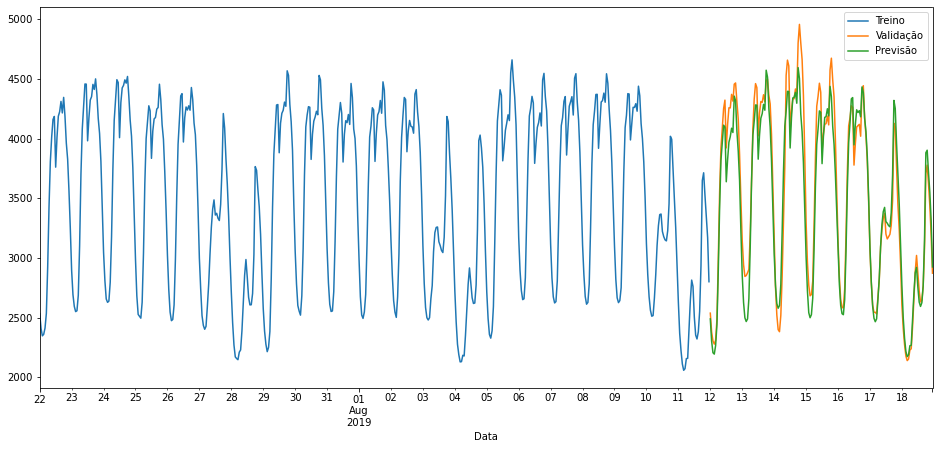

In [201]:
model_7 = ExponentialSmoothing(train_data['Demanda'],
                                    trend='add',
                                    seasonal = 'mul',
                                    seasonal_periods=24*7).fit(smoothing_seasonal=0.4)
predictions_7 = model_7.forecast(len(valid_data))
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,7));
valid_data['Demanda'].plot(legend=True, label='Validação', figsize=(16,7));
predictions_7.plot(legend=True, label='Previsão', figsize=(16,7));

In [151]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_7))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 192.11


***1.8 Tendência advitiva e sazonalidade multiplicativa. Alterando parâmetros:smoothing_seasonal=0,4 e smoothing_level=0,6.***

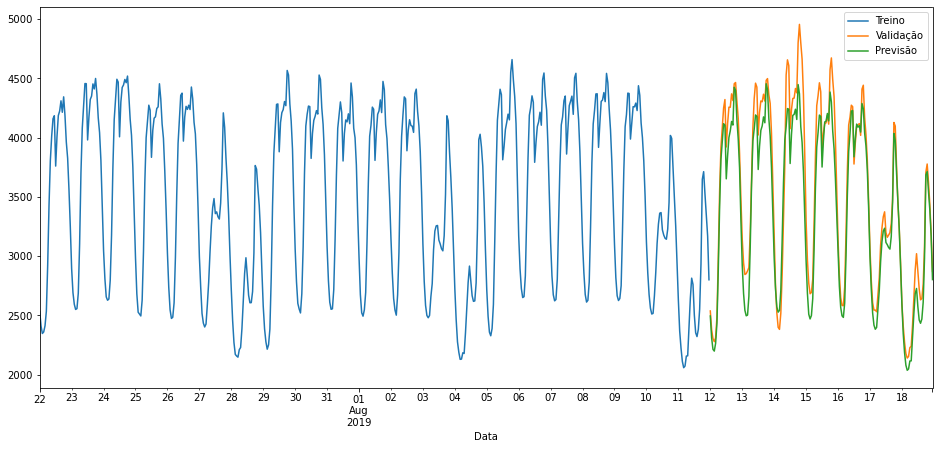

In [202]:
model_8 = ExponentialSmoothing(train_data['Demanda'],
                                    trend='add',
                                    seasonal = 'mul',
                                    seasonal_periods=24*7).fit(smoothing_seasonal=0.4, smoothing_level = 0.6)
predictions_8 = model_8.forecast(len(valid_data))
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,7));
valid_data['Demanda'].plot(legend=True, label='Validação', figsize=(16,7));
predictions_8.plot(legend=True, label='Previsão', figsize=(16,7));

In [166]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_8))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 215.87


**1.9 Treinar com todos os dados o melhor modelo**

In [167]:
train_data  = data.iloc[:int(((len(data)-1)/5)*4)]
test_data = data.iloc[int(((len(data)-1)/5)*4):-1]

In [203]:
model = ExponentialSmoothing(train_data['Demanda'],
                                    trend='add',
                                    seasonal = 'mul',
                                    seasonal_periods=24*7).fit(smoothing_seasonal=0.4, smoothing_level=0.6)
test_predictions = model.forecast(len(test_data));

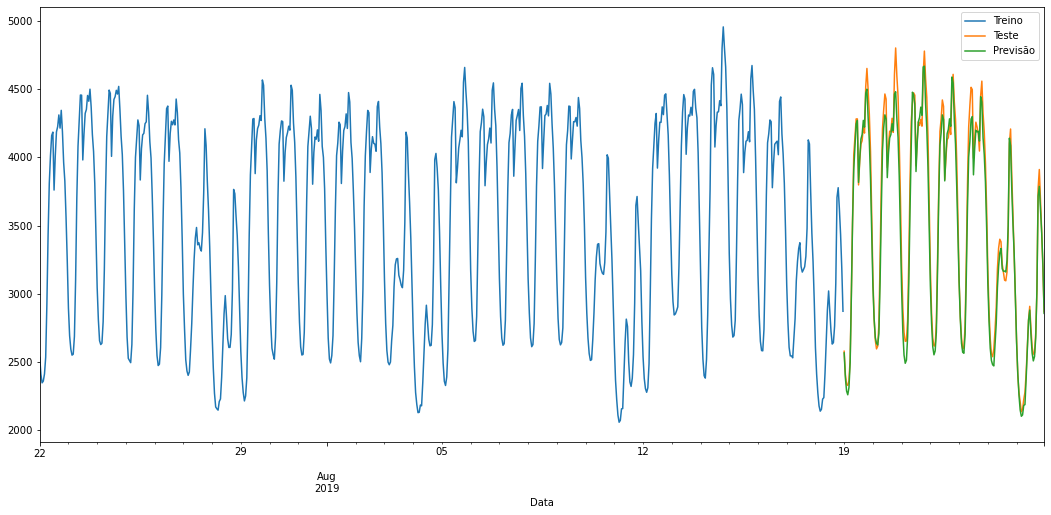

In [181]:
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(18,8))
test_data['Demanda'].plot(legend=True, label='Teste', figsize=(18,8))
test_predictions.plot(legend=True, label='Previsão', figsize=(18,8));

*Detalhe da previsão*

<AxesSubplot:xlabel='Data'>

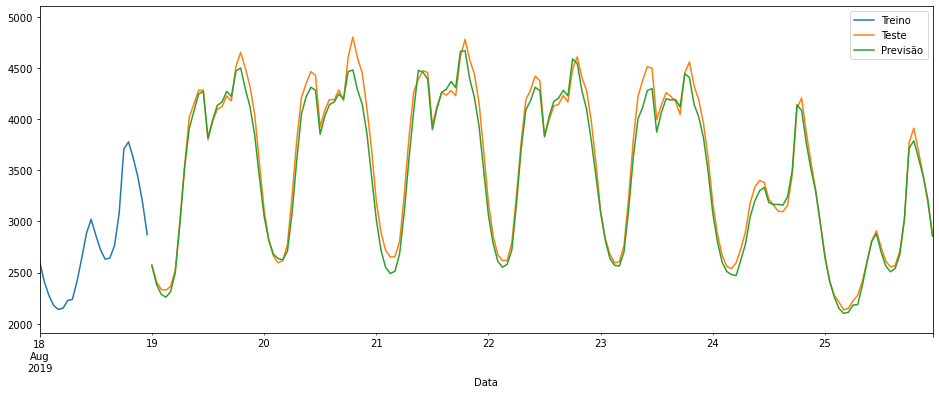

In [178]:
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(16,6))
test_data['Demanda'].plot(legend=True, label='Teste', figsize=(16,6))
test_predictions.plot(legend=True, label='Previsão', figsize=(16,6), xlim=[train_data.index[-24],test_data.index[-1]])

In [179]:
rms = np.sqrt(mean_squared_error(test_data.Demanda, test_predictions))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 113.32


**2 - SARIMA**

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

**Divisão dos dados**

In [16]:
train_data  = data.iloc[:int(((len(data)-1)/5)*3)]
valid_data = data.iloc[int(((len(data)-1)/5)*3):int(((len(data)-1)/5)*4)]
test_data = data.iloc[int(((len(data)-1)/5)*4):]

Para a escolha dos parâmetros vamos nos utilizar de algumas informações que encontramos na análise. Como os dados são não estacionários, utilizaremos d=1 e D=1. m=168

**1.1 SARIMA(1,1,1)(1,0,1,168)**

In [18]:
modelar_1 = SARIMAX(train_data['Demanda'], order=(1,1,1),seasonal_order=(1,0,1,168))
results = modelar_1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Demanda   No. Observations:                  504
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 168)   Log Likelihood               -2956.328
Date:                             Mon, 17 Aug 2020   AIC                           5922.657
Time:                                     12:04:43   BIC                           5943.760
Sample:                                 07-22-2019   HQIC                          5930.936
                                      - 08-11-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3465      0.112      3.096      0.002       0.127       0.566
ma.L1          0.1081      0.116      0.933      0.351      -0.119       0.335
ar.S.L168      0.9979      0.003    366.586      0.000       0.993       1.003
ma.S.L168     -0.7359      0.152     -4.831      0.000      -1.034      -0.437
sigma2      2371.3331    301.001      7.878      0.000    1781.381    2961.285
===================================================================================
Ljung-Box (Q):                      292.60   Jarque-Bera (JB):               182.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.74
Prob(H) (two-sided):                  0.41   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_1 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,1)(1,0,168) Predictions')

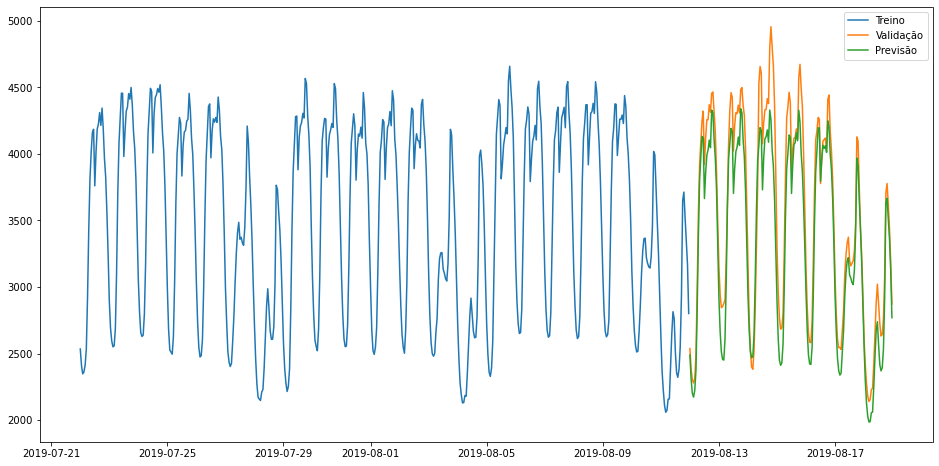

In [20]:
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_1, label='Previsão')
plt.legend(loc='best')
plt.show()

In [21]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_1))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 250.88


**1.2 SARIMA(1,1,1)(1,1,1,168)**

In [22]:
modelar_2 = SARIMAX(train_data['Demanda'], order=(1,1,1),seasonal_order=(1,1,1,168))
results = modelar_2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Demanda   No. Observations:                  504
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 168)   Log Likelihood               -1821.080
Date:                             Mon, 17 Aug 2020   AIC                           3652.159
Time:                                     12:12:24   BIC                           3671.230
Sample:                                 07-22-2019   HQIC                          3659.762
                                      - 08-11-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0638      0.214      0.297      0.766      -0.356       0.484
ma.L1          0.2242      0.203      1.107      0.268      -0.173       0.621
ar.S.L168      0.0788     14.153      0.006      0.996     -27.661      27.818
ma.S.L168     -0.4108     16.346     -0.025      0.980     -32.448      31.626
sigma2      2902.6530   4493.677      0.646      0.518   -5904.791    1.17e+04
===================================================================================
Ljung-Box (Q):                      118.87   Jarque-Bera (JB):               192.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.79
Prob(H) (two-sided):                  0.06   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_2 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,1,1)(1,0,168) Predictions')

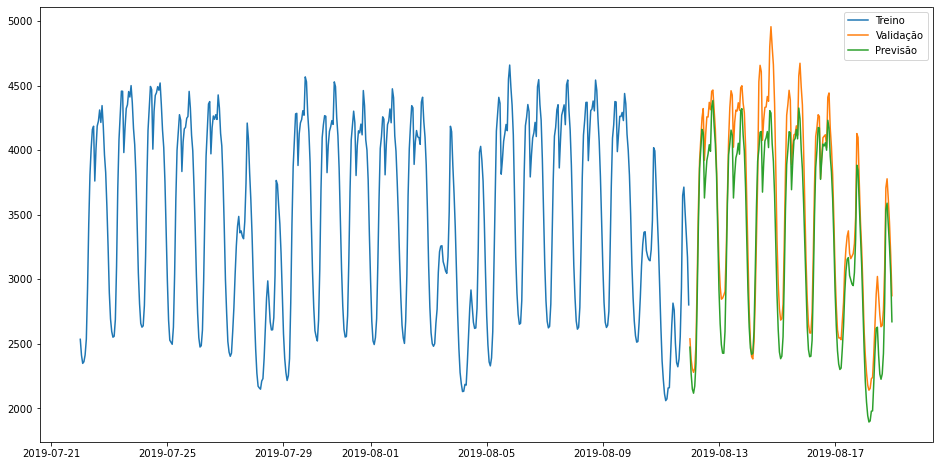

In [24]:
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_2, label='Previsão')
plt.legend(loc='best')
plt.show()

In [25]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_2))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 279.37


**1.3 SARIMA(3,1,1)(1,1,1,168)**

In [204]:
modelar_3 = SARIMAX(train_data['Demanda'], order=(3,1,1),seasonal_order=(1,1,1,168))
results = modelar_3.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Demanda   No. Observations:                  504
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 168)   Log Likelihood               -1817.860
Date:                             Mon, 17 Aug 2020   AIC                           3649.720
Time:                                     09:14:56   BIC                           3676.419
Sample:                                 07-22-2019   HQIC                          3660.364
                                      - 08-11-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5640      0.136     -4.152      0.000      -0.830      -0.298
ar.L2          0.1783      0.080      2.239      0.025       0.022       0.334
ar.L3         -0.1422      0.064     -2.210      0.027      -0.268      -0.016
ma.L1          0.8635      0.133      6.506      0.000       0.603       1.124
ar.S.L168     -0.8277      9.388     -0.088      0.930     -19.229      17.573
ma.S.L168      0.6183     12.313      0.050      0.960     -23.515      24.752
sigma2      2767.4652   7247.305      0.382      0.703   -1.14e+04     1.7e+04
===================================================================================
Ljung-Box (Q):                      111.14   Jarque-Bera (JB):               175.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.77
Prob(H) (two-sided):                  0.03   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [205]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_3 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(3,1,1)(1,1,168) Predictions')

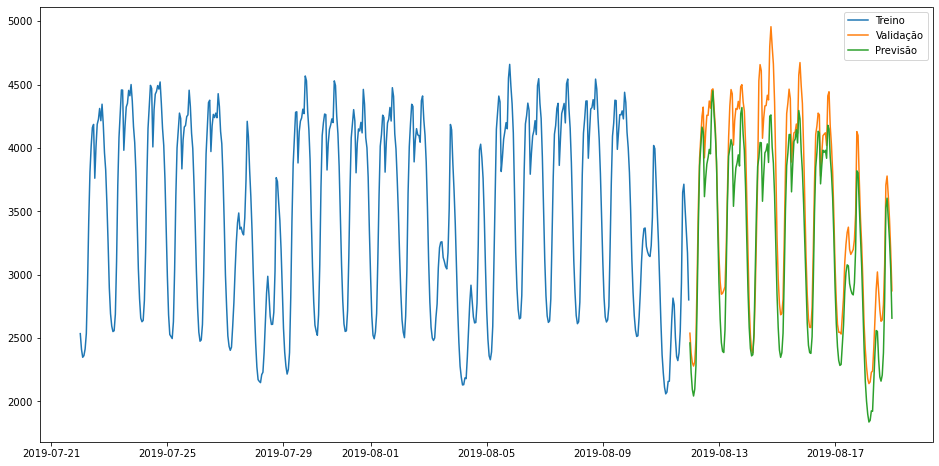

In [206]:
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_3, label='Previsão')
plt.legend(loc='best')
plt.show()

In [207]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_3))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 319.73


**1.4 SARIMA(2,1,1)(1,1,1,168)**

In [208]:
modelar_4 = SARIMAX(train_data['Demanda'], order=(2,1,1),seasonal_order=(1,1,1,168))
results = modelar_4.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Demanda   No. Observations:                  504
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 168)   Log Likelihood               -1808.868
Date:                             Mon, 17 Aug 2020   AIC                           3629.736
Time:                                     09:23:30   BIC                           3652.621
Sample:                                 07-22-2019   HQIC                          3638.859
                                      - 08-11-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1925      0.054     21.968      0.000       1.086       1.299
ar.L2         -0.3436      0.049     -7.035      0.000      -0.439      -0.248
ma.L1         -0.9696      0.024    -40.559      0.000      -1.016      -0.923
ar.S.L168      0.3639      6.273      0.058      0.954     -11.932      12.659
ma.S.L168     -0.9161     31.337     -0.029      0.977     -62.335      60.503
sigma2      2227.2225   5.57e+04      0.040      0.968   -1.07e+05    1.11e+05
===================================================================================
Ljung-Box (Q):                       93.73   Jarque-Bera (JB):               101.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.65
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [209]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_4 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,1,1)(1,1,168) Predictions')

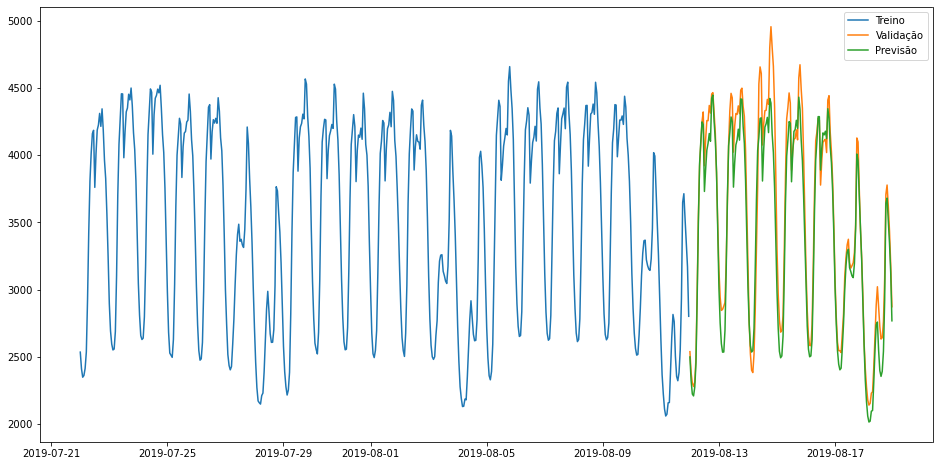

In [210]:
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_4, label='Previsão')
plt.legend(loc='best')
plt.show()

In [211]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_4))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 195.06


**1.5 SARIMA (1,1,2)(1,1,1,168)**

In [212]:
modelar_5 = SARIMAX(train_data['Demanda'], order=(1,1,2),seasonal_order=(1,1,1,168))
results = modelar_5.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               Demanda   No. Observations:                  504
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 168)   Log Likelihood               -1817.381
Date:                               Mon, 17 Aug 2020   AIC                           3646.762
Time:                                       09:31:53   BIC                           3669.647
Sample:                                   07-22-2019   HQIC                          3655.885
                                        - 08-11-2019                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9185      0.087    -10.618      0.000      -1.088      -0.749
ma.L1          1.2549      0.097     12.900      0.000       1.064       1.446
ma.L2          0.3539      0.053      6.699      0.000       0.250       0.457
ar.S.L168     -0.8810      9.995     -0.088      0.930     -20.470      18.708
ma.S.L168      0.6889     14.618      0.047      0.962     -27.963      29.341
sigma2      2703.3253   1.17e+04      0.231      0.817   -2.02e+04    2.56e+04
===================================================================================
Ljung-Box (Q):                      103.94   Jarque-Bera (JB):               172.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.75
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [213]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_5 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(3,1,1)(1,1,168) Predictions')

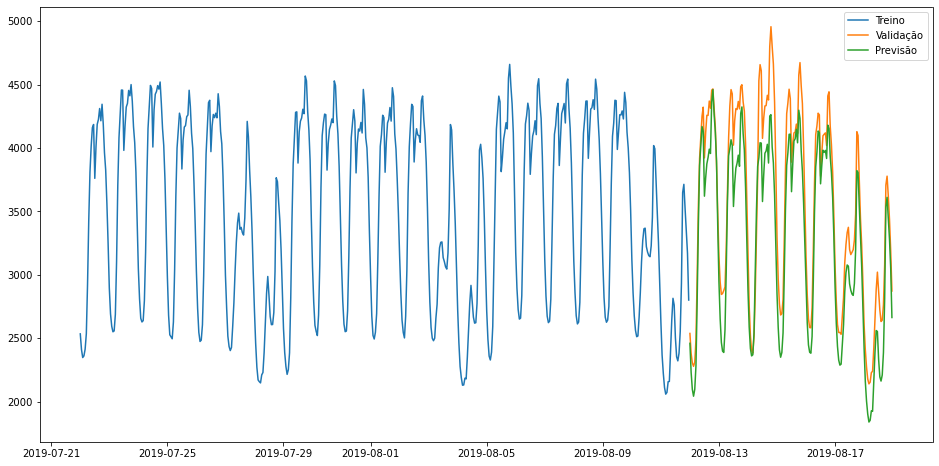

In [214]:
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_5, label='Previsão')
plt.legend(loc='best')
plt.show()

In [215]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_5))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 317.85


**1.6 SARIMA (1,1,3)(1,1,1,168)**

In [216]:
modelar_6 = SARIMAX(train_data['Demanda'], order=(1,1,3),seasonal_order=(1,1,1,168))
results = modelar_6.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               Demanda   No. Observations:                  504
Model:             SARIMAX(1, 1, 3)x(1, 1, [1], 168)   Log Likelihood               -1809.619
Date:                               Mon, 17 Aug 2020   AIC                           3633.238
Time:                                       09:41:36   BIC                           3659.937
Sample:                                   07-22-2019   HQIC                          3643.882
                                        - 08-11-2019                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8306      0.049     16.829      0.000       0.734       0.927
ma.L1         -0.6162      0.085     -7.217      0.000      -0.784      -0.449
ma.L2         -0.2799      0.063     -4.474      0.000      -0.402      -0.157
ma.L3         -0.1000      0.068     -1.463      0.144      -0.234       0.034
ar.S.L168      0.3207      6.667      0.048      0.962     -12.747      13.388
ma.S.L168     -0.7699     12.490     -0.062      0.951     -25.251      23.711
sigma2      2447.3723   1.38e+04      0.177      0.860   -2.47e+04    2.96e+04
===================================================================================
Ljung-Box (Q):                       96.15   Jarque-Bera (JB):               107.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.66
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

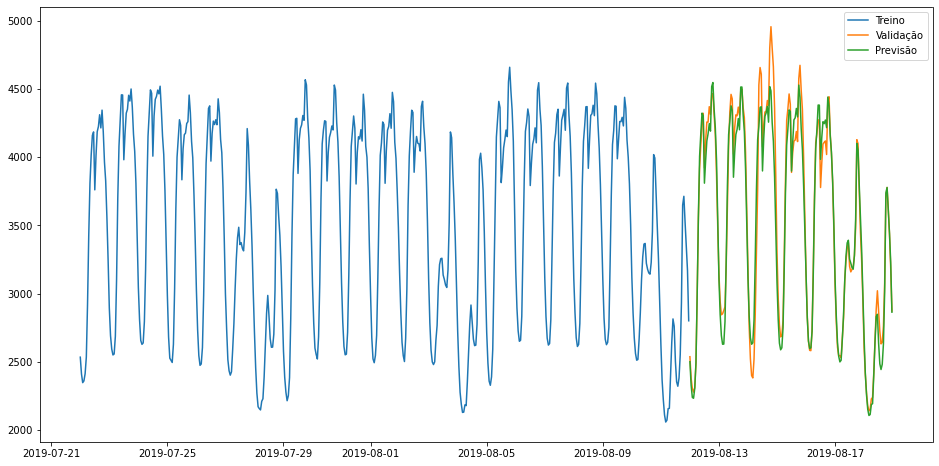

In [217]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_6 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,1,2)(1,1,168) Predictions')
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_6, label='Previsão')
plt.legend(loc='best')
plt.show()

In [218]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_6))
print("Erro Quadrático Médio (RMS):", round(rms,2))

Erro Quadrático Médio (RMS): 153.63


**1.7 SARIMA (2,1,3)(1,1,1,168)**

In [26]:
modelar_7 = SARIMAX(train_data['Demanda'], order=(2,1,3),seasonal_order=(1,1,1,168))
results = modelar_7.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               Demanda   No. Observations:                  504
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 168)   Log Likelihood               -1806.257
Date:                               Mon, 17 Aug 2020   AIC                           3628.514
Time:                                       12:28:52   BIC                           3659.027
Sample:                                   07-22-2019   HQIC                          3640.679
                                        - 08-11-2019                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0718      0.084     -0.852      0.394      -0.237       0.093
ar.L2          0.7727      0.081      9.528      0.000       0.614       0.932
ma.L1          0.3144      0.114      2.750      0.006       0.090       0.538
ma.L2         -0.8985      0.115     -7.845      0.000      -1.123      -0.674
ma.L3         -0.4113      0.064     -6.422      0.000      -0.537      -0.286
ar.S.L168      0.3512      5.960      0.059      0.953     -11.331      12.033
ma.S.L168     -0.8030     12.343     -0.065      0.948     -24.995      23.389
sigma2      2374.0760   1.49e+04      0.160      0.873   -2.68e+04    3.15e+04
===================================================================================
Ljung-Box (Q):                       90.80   Jarque-Bera (JB):                92.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.63
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

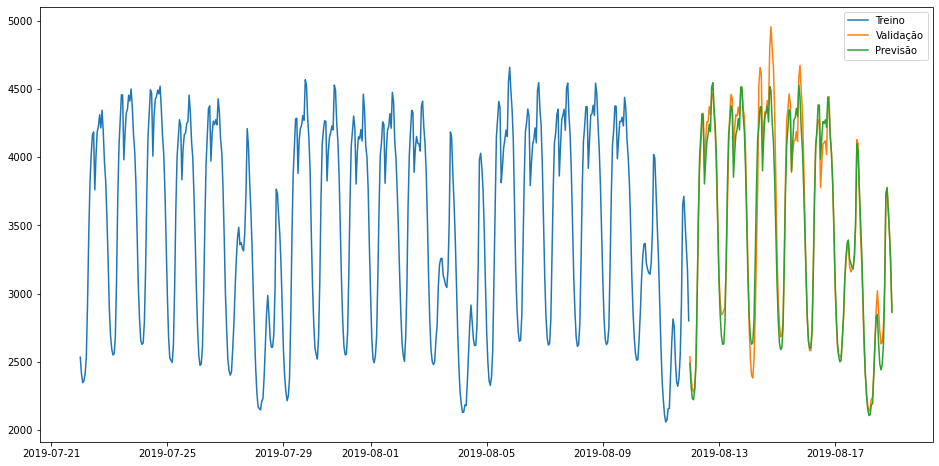

In [27]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_7 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,1,3)(1,1,168) Predictions')
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_7, label='Previsão')
plt.legend(loc='best')
plt.show()

In [28]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_7))
print("Erro Quadrático Médio (RMS):", round(rms))

Erro Quadrático Médio (RMS): 154


**1.8 SARIMA (2,1,3)(1,1,2,168)**

In [29]:
modelar_8 = SARIMAX(train_data['Demanda'], order=(2,1,3),seasonal_order=(1,1,2,168))
results = modelar_8.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:                                  Demanda   No. Observations:                  504
Model:             SARIMAX(2, 1, 3)x(1, 1, [1, 2], 168)   Log Likelihood               -1806.107
Date:                                  Mon, 17 Aug 2020   AIC                           3630.214
Time:                                          13:15:54   BIC                           3664.542
Sample:                                      07-22-2019   HQIC                          3643.900
                                           - 08-11-2019                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0704      0.084     -0.839      0.402      -0.235       0.094
ar.L2          0.7718      0.082      9.414      0.000       0.611       0.932
ma.L1          0.3114      0.261      1.195      0.232      -0.199       0.822
ma.L2         -0.8993      0.330     -2.727      0.006      -1.546      -0.253
ma.L3         -0.4108      0.115     -3.571      0.000      -0.636      -0.185
ar.S.L168     -0.5516     15.432     -0.036      0.971     -30.798      29.695
ma.S.L168     -0.0897     32.623     -0.003      0.998     -64.030      63.850
ma.S.L336     -0.8067     11.863     -0.068      0.946     -24.058      22.444
sigma2      1710.7132      0.038   4.54e+04      0.000    1710.639    1710.787
===================================================================================
Ljung-Box (Q):                       91.16   Jarque-Bera (JB):                93.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.63
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.94e+21. Standard errors may be unstable.
"""

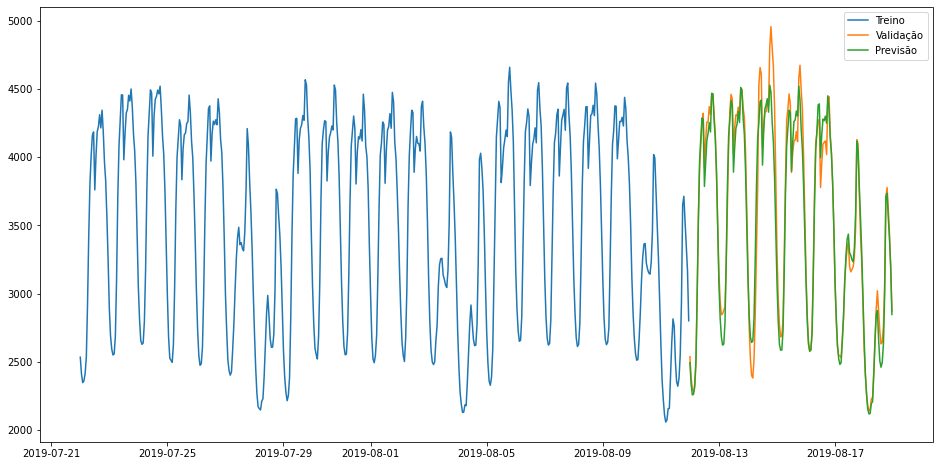

In [30]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_8 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,1,1)(1,1,168) Predictions')
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_8, label='Previsão')
plt.legend(loc='best')
plt.show()

In [31]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_8))
print("Erro Quadrático Médio (RMS):", round(rms))

Erro Quadrático Médio (RMS): 154


**1.9 SARIMA (2,1,3)(2,1,1,168)**

In [17]:
modelar_9 = SARIMAX(train_data['Demanda'], order=(2,1,3),seasonal_order=(2,1,1,168))
results = modelar_9.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               Demanda   No. Observations:                  504
Model:             SARIMAX(2, 1, 3)x(2, 1, [1], 168)   Log Likelihood               -1806.023
Date:                               Mon, 17 Aug 2020   AIC                           3630.047
Time:                                       14:35:00   BIC                           3664.374
Sample:                                   07-22-2019   HQIC                          3643.732
                                        - 08-11-2019                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0712      0.084     -0.846      0.398      -0.236       0.094
ar.L2          0.7722      0.082      9.382      0.000       0.611       0.933
ma.L1          0.3121      0.367      0.849      0.396      -0.408       1.032
ma.L2         -0.8997      0.479     -1.877      0.060      -1.839       0.040
ma.L3         -0.4115      0.161     -2.557      0.011      -0.727      -0.096
ar.S.L168     -0.3564    176.860     -0.002      0.998    -346.995     346.283
ar.S.L336     -0.6496     54.643     -0.012      0.991    -107.748     106.449
ma.S.L168     -0.3288    407.921     -0.001      0.999    -799.840     799.182
sigma2      1292.9856   1.74e+05      0.007      0.994    -3.4e+05    3.43e+05
===================================================================================
Ljung-Box (Q):                       91.64   Jarque-Bera (JB):                92.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.63
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

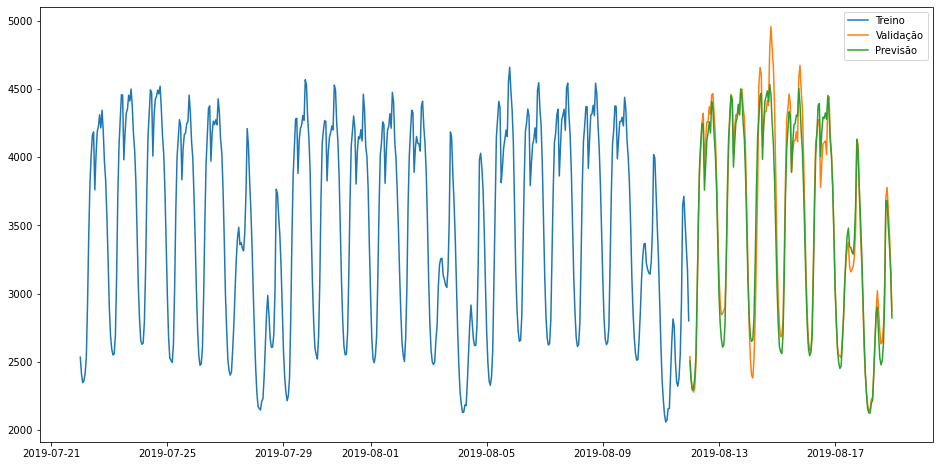

In [18]:
start=len(train_data)
end=len(train_data)+len(valid_data)-1
predictions_9 = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(2,1,3)(1,1,168) Predictions')
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(valid_data['Demanda'], label='Validação')
plt.plot(predictions_9, label='Previsão')
plt.legend(loc='best')
plt.show()

In [19]:
rms = np.sqrt(mean_squared_error(valid_data.Demanda, predictions_9))
print("Erro Quadrático Médio (RMS):", round(rms))

Erro Quadrático Médio (RMS): 162



**1.10 - Treinar o melhor modelo com todos os dados**

In [20]:
train_data  = data.iloc[:int(((len(data)-1)/5)*4)]
test_data = data.iloc[int(((len(data)-1)/5)*4):]

In [21]:
modelar_7 = SARIMAX(train_data['Demanda'], order=(2,1,3),seasonal_order=(1,1,1,168))
results = modelar_7.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               Demanda   No. Observations:                  672
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 168)   Log Likelihood               -2782.266
Date:                               Mon, 17 Aug 2020   AIC                           5580.531
Time:                                       14:55:58   BIC                           5614.296
Sample:                                   07-22-2019   HQIC                          5593.777
                                        - 08-18-2019                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4758      0.423      1.126      0.260      -0.353       1.304
ar.L2          0.2328      0.350      0.666      0.506      -0.452       0.918
ma.L1         -0.2373      0.432     -0.549      0.583      -1.085       0.610
ma.L2         -0.5127      0.289     -1.775      0.076      -1.079       0.053
ma.L3         -0.2479      0.165     -1.506      0.132      -0.571       0.075
ar.S.L168      0.0321      0.161      0.199      0.842      -0.284       0.349
ma.S.L168     -0.4946      0.170     -2.915      0.004      -0.827      -0.162
sigma2      3314.1324    271.122     12.224      0.000    2782.743    3845.522
===================================================================================
Ljung-Box (Q):                      161.91   Jarque-Bera (JB):              6624.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             2.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(2,1,3)(1,1,168) Predictions')


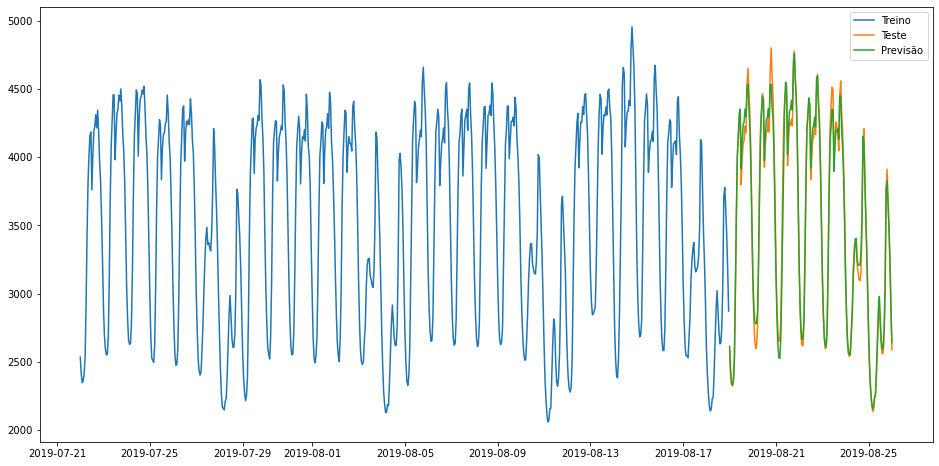

In [23]:
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(test_data['Demanda'], label='Teste')
plt.plot(predictions, label='Previsão')
plt.legend(loc='best')
plt.show()

In [24]:
rms = np.sqrt(mean_squared_error(test_data.Demanda, predictions))
print("Erro Quadrático Médio (RMS):", round(rms))

Erro Quadrático Médio (RMS): 87


***Detalhe da Previsão***

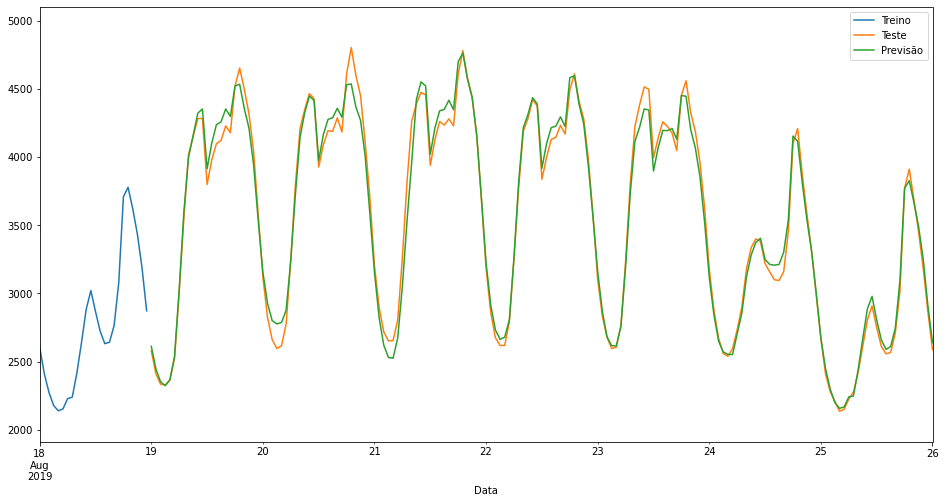

In [25]:
plt.figure(figsize=(16,8))
train_data['Demanda'].plot(label='Treino')
test_data['Demanda'].plot(label='Teste')
predictions.plot(label='Previsão', xlim=[train_data.index[-24],test_data.index[-1]])
plt.legend(loc='best')
plt.show()

### Teste em Dezembro

Relização de teste dos modelos em uma semana atípica, como a última de dezembro.

#### Holt-Winters

In [14]:
data_2  = df_new.loc['2019-11-26 00:00:00':'2019-12-31 23:00:00']

In [15]:
train_data  = data_2.iloc[:int(((len(data_2)-1)/5)*4)]
test_data = data_2.iloc[int(((len(data_2)-1)/5)*4):]

In [16]:
model = ExponentialSmoothing(train_data['Demanda'],
                                    trend='add',
                                    seasonal = 'mul',
                                    seasonal_periods=24*7).fit(smoothing_seasonal=0.4, smoothing_level=0.6)
test_predictions = model.forecast(len(test_data))

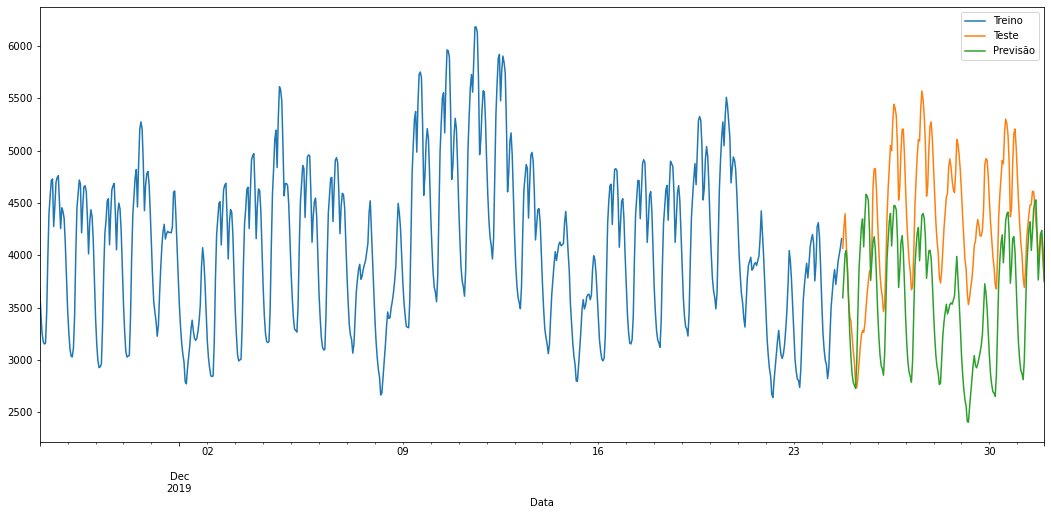

In [17]:
train_data['Demanda'].plot(legend=True, label='Treino', figsize=(18,8))
test_data['Demanda'].plot(legend=True, label='Teste', figsize=(18,8))
test_predictions.plot(legend=True, label='Previsão', figsize=(18,8));

In [19]:
rms = np.sqrt(mean_squared_error(test_data.Demanda, test_predictions))
print("Erro Quadrático Médio (RMS):", round(rms))

Erro Quadrático Médio (RMS): 943


In [36]:
modelar_7 = SARIMAX(train_data['Demanda'], order=(2,1,3),seasonal_order=(1,1,1,168))
results = modelar_7.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                               Demanda   No. Observations:                  690
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 168)   Log Likelihood               -2965.255
Date:                               Mon, 17 Aug 2020   AIC                           5946.511
Time:                                       15:27:23   BIC                           5980.557
Sample:                                   11-26-2019   HQIC                          5959.847
                                        - 12-24-2019                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3706      0.057      6.479      0.000       0.259       0.483
ar.L2         -0.8163      0.045    -18.205      0.000      -0.904      -0.728
ma.L1          0.2152      0.064      3.373      0.001       0.090       0.340
ma.L2          0.7723      0.034     22.974      0.000       0.706       0.838
ma.L3          0.5011      0.050     10.078      0.000       0.404       0.598
ar.S.L168      0.4051      0.239      1.696      0.090      -0.063       0.873
ma.S.L168     -0.7155      0.302     -2.371      0.018      -1.307      -0.124
sigma2      5166.7266    485.393     10.644      0.000    4215.374    6118.079
===================================================================================
Ljung-Box (Q):                      177.11   Jarque-Bera (JB):               192.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(2,1,3)(1,1,168) Predictions')

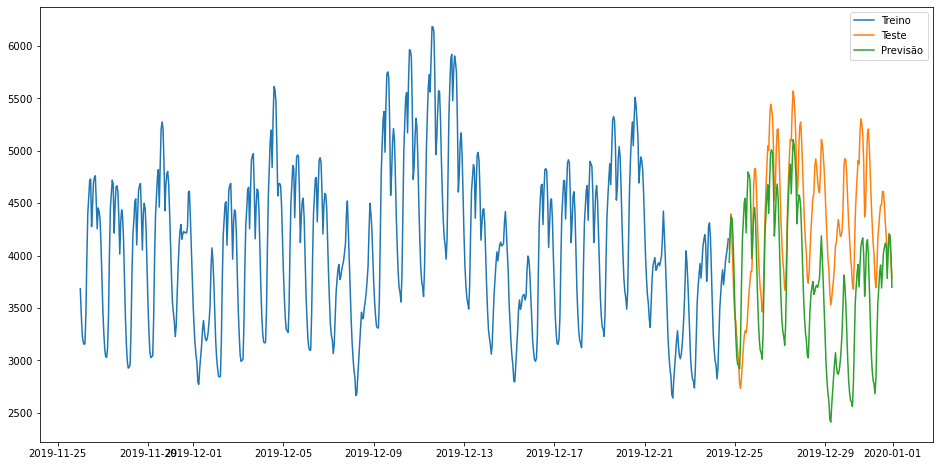

In [38]:
plt.figure(figsize=(16,8))
plt.plot(train_data['Demanda'], label='Treino')
plt.plot(test_data['Demanda'], label='Teste')
plt.plot(predictions, label='Previsão')
plt.legend(loc='best')
plt.show()

In [39]:
rms = np.sqrt(mean_squared_error(test_data.Demanda, predictions))
print("Erro Quadrático Médio (RMS):", round(rms))

Erro Quadrático Médio (RMS): 854
